In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt

In [2]:
# case can be "rgb_rad, rgb_angle, depth_rad or depth_angle"

case = 'rgb_rad'

ver = 3

In [3]:
class LateFusionNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(LateFusionNet, self).__init__()
        # Separate convolutional layers for RGB and depth streams
        self.conv_rgb = torchvision.models.resnet18(pretrained=False)
        self.conv_rgb.fc = torch.nn.Identity()
        
        self.conv_depth = torchvision.models.resnet18(pretrained=False)
        self.conv_depth.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv_depth.fc = torch.nn.Identity()
        
        # Fully connected layers for fusion
        self.fc1 = torch.nn.Linear(512 * 2, 128)  # Concatenating features from both streams
        self.fc2 = torch.nn.Linear(128, num_classes)  # Adjust num_classes based on your task
        
    def forward(self, rgbd_inputs):
        rgb_inputs = rgbd_inputs[:,:3,:,:]
        depth_inputs = rgbd_inputs[:,3,:,:].unsqueeze(1)

        # Forward pass for RGB stream
        rgb_features = self.conv_rgb(rgb_inputs)
        # Forward pass for depth stream
        depth_features = self.conv_depth(depth_inputs)
        
        # Concatenate features from both streams
        combined_features = torch.cat((rgb_features, depth_features), dim=1)
        
        # Fully connected layers for fusion
        x = self.fc1(combined_features)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


In [4]:
class rgbd_dataset(torch.utils.data.Dataset):
    def __init__(self, rgb_dataset, depth_dataset, transform=None):
        self.rgb_dataset = rgb_dataset
        self.depth_dataset = depth_dataset
        self.transform = transform

    def __len__(self):
        return len(self.rgb_dataset)

    def __getitem__(self, idx):
        rgb_img, rgb_label = self.rgb_dataset[idx]
        depth_img, _ = self.depth_dataset[idx]

        # Convert depth image to single-channel grayscale
        depth_img = torch.mean(depth_img, dim=0, keepdim=True)

        # Concatenate RGB and depth images along the channel dimension
        rgbd_img = torch.cat([rgb_img, depth_img], dim=0)

        # Apply transformations if provided
        if self.transform:
            rgbd_img = self.transform(rgbd_img)

        # Return the rgbd_img and the label from the RGB image
        return rgbd_img, rgb_label

In [5]:
if case.split('_')[1] == 'angle':
    rgb_data_dir = './dataset/train/angle/rgb'
    depth_data_dir = './dataset/train/angle/depth'
    classes = os.listdir(rgb_data_dir)
    
elif case.split('_')[1] == 'rad':
    rgb_data_dir = './dataset/train/rad/rgb'
    depth_data_dir = './dataset/train/rad/depth'
    classes = os.listdir(rgb_data_dir)
    
print(classes)

['0', '1', '2', '3', '4', '5']


In [6]:
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, len(classes))

if case.split('_')[0] == 'depth':
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# elif case.split('_')[0] == 'rgb':
  # model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    
elif case.split('_')[0] == 'Ergbd':
    model.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

elif case.split('_')[0] == 'Lrgbd':
    model = LateFusionNet(len(classes))

model.eval()

weights = './Weights/' + case + '_v' + str(ver) + '.pth'
model.load_state_dict(torch.load(weights)) # Load weights
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if case.split('_')[0] == 'Lrgbd':
    cam_extractor = SmoothGradCAMpp(model.conv_rgb)
else:
    cam_extractor = SmoothGradCAMpp(model)

In [7]:
rgb_train_transfor = transforms.Compose([transforms.ToTensor(),
                                        transforms.ColorJitter(brightness=.5, hue=.1, saturation=[0.5, 1.5], contrast=[0.5, 1.5]),
                                        ])
rgb_val_transform = transforms.Compose([transforms.ToTensor(),
                                                    ])
depth_train_transfor = transforms.Compose([transforms.ToTensor(),
                                        transforms.Grayscale(num_output_channels=1),
                                      ])    
depth_val_transform = transforms.Compose([transforms.ToTensor(), 
                                                    transforms.Grayscale(num_output_channels=1),
                                                    ])

RandomCrop_transform = transforms.Compose([transforms.RandomCrop(240, padding=25)])

rgb_ds_train = ImageFolder(rgb_data_dir, transform=rgb_train_transfor)
depth_ds_train = ImageFolder(depth_data_dir, transform=depth_train_transfor)

rgb_ds = ImageFolder(rgb_data_dir, transform=rgb_val_transform)
depth_ds = ImageFolder(depth_data_dir, transform=depth_val_transform)

train_size = int(0.9985 * len(rgb_ds))
val_size = len(rgb_ds) - train_size

rgb_train_ds, rgb_val_ds = torch.utils.data.random_split(rgb_ds, [train_size, val_size])
depth_train_ds = torch.utils.data.Subset(depth_ds, rgb_train_ds.indices)
depth_val_ds = torch.utils.data.Subset(depth_ds, rgb_val_ds.indices)

if case.split('_')[0] == 'rgb':
  val_ds = rgb_val_ds
     
if case.split('_')[0] == 'depth':
  val_ds = depth_val_ds
      
elif 'rgbd' in case.split('_')[0]:
  val_ds = rgbd_dataset(rgb_val_ds, depth_val_ds)


In [8]:
def activation_map(img, model, device):
    
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get prediction from model
    yb = model(xb.to(device))
    
    if case.split('_')[0] == 'depth':
        img = img.repeat(3, 1, 1)
    # Get the normalized probability vector
    activation_map = cam_extractor(yb.squeeze(0).argmax().item(), yb)
    result = overlay_mask(to_pil_image(img[:3,:,:]), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
    
    return result

def plot(imgs, case, save=False):
    
    save_path = './results/' + case.split('_')[0] + '_v' + str(ver) + '/'
    name = case.split('_')[1] + ' activation map' + '.png'
    fig, ax = plt.subplots(len(imgs)//3,3, figsize=(15, 15))
    
    for ii in range(len(imgs)//3):
        for jj in range(3):
            ax[ii,jj].imshow(imgs[ii+jj*3])
            ax[ii,jj].set_axis_off()
            
    if save: plt.savefig(os.path.join(save_path, name))
    plt.show()

In [9]:
CAM_images = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

for data in val_ds:
    img, _ = data
    activation_img = activation_map(img, model, device)
    CAM_images.append(activation_img)


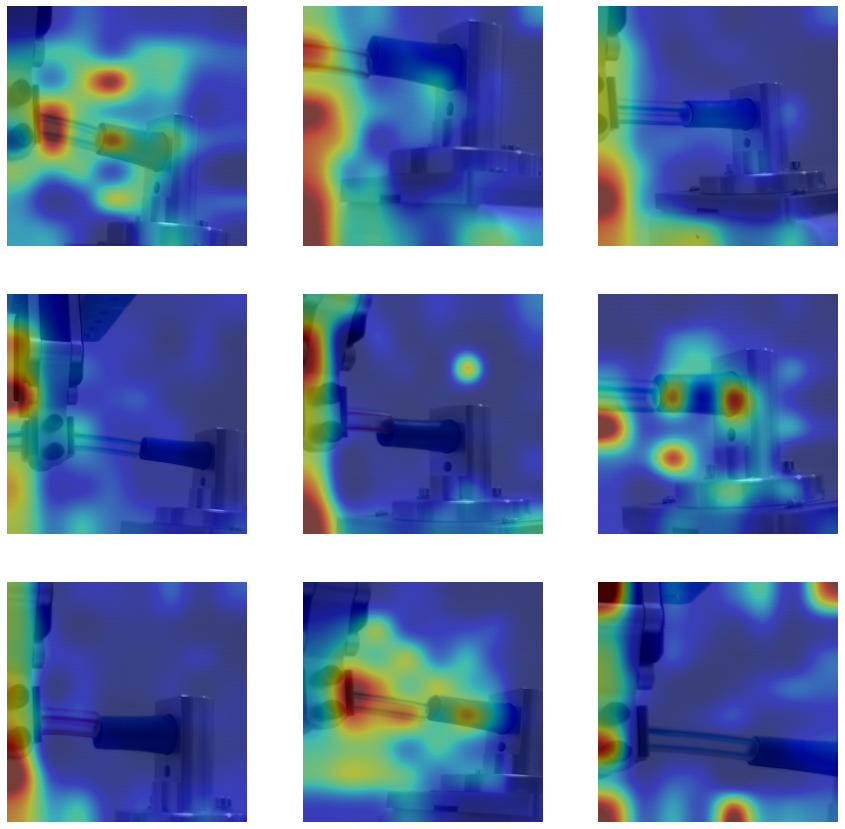

In [10]:
plot(CAM_images, case, save = False)